# Computationally-defined markers of uncertainty aversion predict trajectories of perceived threat and anxiety during a global pandemic
### Wise\*, Zbozinek\*, Charpentier, Michelini, Hagan & Mobbs (2021)

## Figures for SEM analysis

This could all be done in R but I don't understand ggplot

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import matplotlib as mpl
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
import textwrap
from sklearn.preprocessing import minmax_scale
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from scipy.stats import ttest_1samp
from pingouin import ttest
mpl.style.use('toby')
colours = ['#' + i for i in '267fd3-d3265a-fc9403-44af69'.split('-')] + ['#197278']

## Plotting functions

In [2]:
def plot_LC(res, title=None, ylabels=None, colour='#267fd3', show_ylabels=True, show_xlabel=True, ax=None, highlight_sig=True, ycolours=None, ylabel=''):
    
    """
    This function takes the results of a model and plots the model coefficients of interest
    """
    
    if ax is None:
        f, ax = plt.subplots()
    if ylabels is None:
        ylabels = res.rhs
    if title is None:
        title = res.model_name.values[0]
        
    if ycolours is None:
        plot_colours = np.array(['#757575'] * len(res))
    else:
        plot_colours = ycolours
        
    if highlight_sig:
        plot_colours = np.array(plot_colours)
        plot_colours[res.pvalue > .05] = '#757575'
        
    ax.axvline(0, linestyle=':', color='gray', linewidth=2)

    # Points and error bars
    ax.errorbar(y=np.arange(len(res['est.std'])), x=res['est.std'], 
                 xerr=np.abs(res['ci.lower'].values - res['est.std']), 
                 ecolor=plot_colours, linewidth=2, fmt='none')
    ax.scatter(y=np.arange(len(res['est.std'])), x=res['est.std'], 
                 color=plot_colours)
    # Labels
    ax.set_yticks(range(len(ylabels)))
    if show_ylabels:
        ylabels = [i.replace('_', ' ') for i in ylabels]
        ylabels = [i.replace('param', '') for i in ylabels]
        ax.set_yticklabels(['\n'.join(textwrap.wrap(q, 27, break_long_words=False)) for q in ylabels])
    else:
        ax.set_yticklabels([])
        
    # Y axis label
    ax.set_ylabel(ylabel)

    # Titles etc
    ax.set_title('\n'.join(textwrap.wrap(title.replace('_', ' '), 19, break_long_words=False)))
    
    if show_xlabel:
        ax.set_xlabel('Estimate\n(+/- 95% CI)')


## Factor loadings

This produces a radar plot showing factor loadings

In [3]:
efa_loadings = pd.read_csv('../data/efa_loadings.csv', index_col=0)
efa_loadings['qid'] = efa_loadings.index.str.replace('Q', '').astype(int)
efa_loadings = efa_loadings.sort_values('qid')

factor_labels = ['Behavior', 'General anxiety', 'Virus anxiety', 'Virus likelihood', 'Virus severity']
factors = dict(zip(sorted([c for c in efa_loadings.columns if 'T1' in c]), factor_labels))

efa_loadings = efa_loadings.rename(columns=factors)

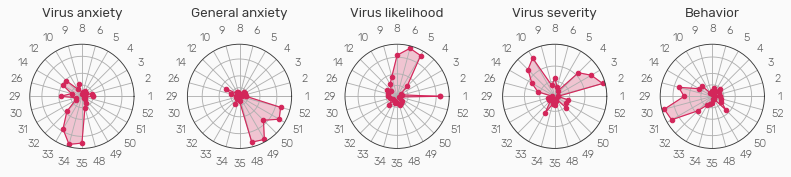

In [4]:
f, ax = plt.subplots(1, 5, figsize=(10, 5), subplot_kw=dict(projection='polar'))

factor_ids = ['Virus anxiety', 'General anxiety', 'Virus likelihood', 'Virus severity', 'Behavior']

titles = ['General anxiety', 'Virus likelihood', 'Behaviour']

for n, i in enumerate(factor_ids):
    # Modified from https://typewind.github.io/2017/09/29/radar-chart/
    labels = efa_loadings['qid']
    stats = efa_loadings[i]
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]])) 
    angles=np.concatenate((angles,[angles[0]])) 
    
    ax[n].plot(angles, stats, 'o-', linewidth=1, color=colours[1], markersize=4)  
    ax[n].fill(angles, stats, alpha=0.25, color=colours[1]) 
    ax[n].set_thetagrids(angles * 180/np.pi, labels)  
    ax[n].set_title(i, y=1.2)  
    ax[n].set_rgrids([0.33, 0.66, 0.1], labels=[], angle=22)
    plt.tight_layout()
    
# plt.savefig('../figures/factor_loadings.svg')

## Get data from R models

### Longitudinal latent change score models

In [5]:
LC_model_summaries = pd.read_csv('../data/sem_outputs/LC_model_summaries.csv')

In [8]:
LC_model_summaries.head()

,lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper,model_name
0,T2,~,T1,1.495320,0.104528,14.305472,0.000000,1.290449,1.700190,result_mb_behavior
1,dT1,~,T1,-0.760573,0.035387,-21.492772,0.000000,-0.829931,-0.691215,result_mb_behavior
2,dT1,~,risk_aversion,-0.161649,0.065322,-2.474650,0.013337,-0.289678,-0.033620,result_mb_behavior
3,dT1,~,loss_aversion,-0.016155,0.075329,-0.214461,0.830188,-0.163797,0.131487,result_mb_behavior
4,dT1,~,Amb_SG,0.000963,0.058341,0.016505,0.986832,-0.113383,0.115309,result_mb_behavior


#### Get model names

In [9]:
LC_model_summaries = LC_model_summaries[LC_model_summaries['rhs'] != 'T1']  # Remove autoregressive effect

model_names = LC_model_summaries['model_name'].unique()
mb_models = [i for i in model_names if '_mb' in i]

#### Create labels for figures

In [10]:
titles = ['Behavior', 'Virus anxiety', 'General anxiety', 'Virus likelihood', 'Virus severity']
MB_var_labels = [r'$\rho$', r'$\lambda$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', r'$\alpha_{RG}$', r'$\alpha_{RL}$', 'Learning rate bias']

#### Plot!

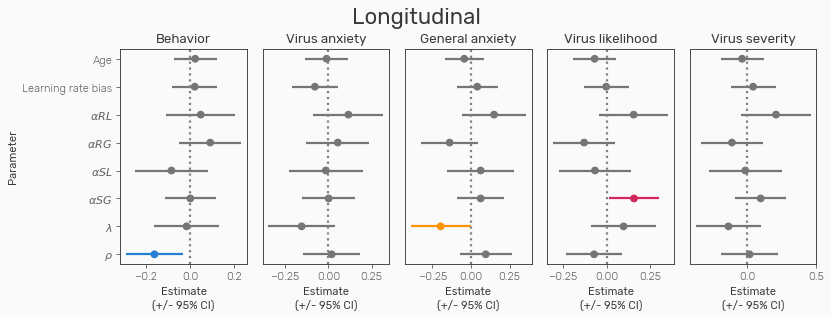

In [12]:
f, ax = plt.subplots(1, len(mb_models), figsize=(2.1 * len(mb_models), 4))

ycolours = np.array(['#757575'] * (len(MB_var_labels) + 1))
ycolours[0] = colours[0]
ycolours[1] = colours[2]
ycolours[[2, 3, 4, 5]] = colours[1]
ycolours[6] = colours[3]
    
for n, m in enumerate(mb_models):
    if n == 0:
        plot_LC(LC_model_summaries[LC_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=MB_var_labels + ['Age'], ycolours=ycolours, ylabel='Parameter')
    else:
        plot_LC(LC_model_summaries[LC_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=[], ycolours=ycolours)
    
plt.tight_layout()

f.suptitle('Longitudinal', fontsize=20)
plt.subplots_adjust(top=0.85)

# plt.savefig('../figures/factors_longitudinal_revised.svg')

### Longitudinal latent change score models, controlling for SES

In [13]:
LC_model_summaries = pd.read_csv('../data/sem_outputs/LC_model_summaries_SES.csv')

In [14]:
LC_model_summaries.head()

,lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper,model_name
0,T2,~,T1,1.501334,0.105291,14.258883,0.000000,1.294967,1.707701,result_mb_behavior
1,dT1,~,T1,-0.762807,0.035137,-21.709670,0.000000,-0.831674,-0.693940,result_mb_behavior
2,dT1,~,risk_aversion,-0.160122,0.065044,-2.461764,0.013826,-0.287605,-0.032639,result_mb_behavior
3,dT1,~,loss_aversion,-0.014068,0.074992,-0.187596,0.851193,-0.161050,0.132913,result_mb_behavior
4,dT1,~,Amb_SG,0.004953,0.058482,0.084698,0.932501,-0.109669,0.119576,result_mb_behavior


#### Get model names

In [15]:
LC_model_summaries = LC_model_summaries[LC_model_summaries['rhs'] != 'T1']  # Remove autoregressive effect

model_names = LC_model_summaries['model_name'].unique()
mb_models = [i for i in model_names if '_mb' in i]

#### Create labels for figures

In [16]:
titles = ['Behavior', 'Virus anxiety', 'General anxiety', 'Virus likelihood', 'Virus severity']
MB_var_labels = [r'$\rho$', r'$\lambda$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', r'$\alpha_{RG}$', r'$\alpha_{RL}$', 'Learning rate bias']

#### Plot!

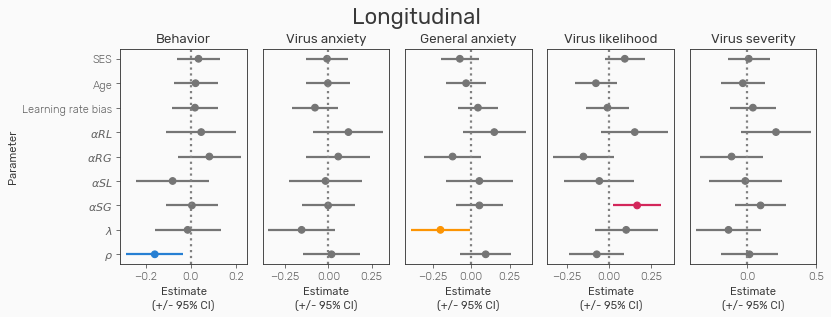

In [64]:
f, ax = plt.subplots(1, len(mb_models), figsize=(2.1 * len(mb_models), 4))

ycolours = np.array(['#757575'] * (len(MB_var_labels) + 2))
ycolours[0] = colours[0]
ycolours[1] = colours[2]
ycolours[[2, 3, 4, 5]] = colours[1]
ycolours[6] = colours[3]
    
for n, m in enumerate(mb_models):
    if n == 0:
        plot_LC(LC_model_summaries[LC_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=MB_var_labels + ['Age', 'SES'], ycolours=ycolours, ylabel='Parameter')
    else:
        plot_LC(LC_model_summaries[LC_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=[], ycolours=ycolours)
    
plt.tight_layout()

f.suptitle('Longitudinal', fontsize=20)
plt.subplots_adjust(top=0.85)

# plt.savefig('../figures/factors_longitudinal_SES_revised.svg')

## Cross sectional latent path models

In [18]:
latent_path_model_summaries = pd.read_csv('../data/sem_outputs/latent_path_model_summaries.csv')

latent_path_model_summaries['model_name'] = latent_path_model_summaries['model_name'] + '_' + latent_path_model_summaries['lhs']
model_names = latent_path_model_summaries['model_name'].unique()

titles = ['Behavior', 'Virus anxiety', 'General anxiety', 'Virus likelihood', 'Virus severity']
MB_var_labels = [r'$\rho$', r'$\lambda$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', r'$\alpha_{RG}$', r'$\alpha_{RL}$', 'Learning rate bias']

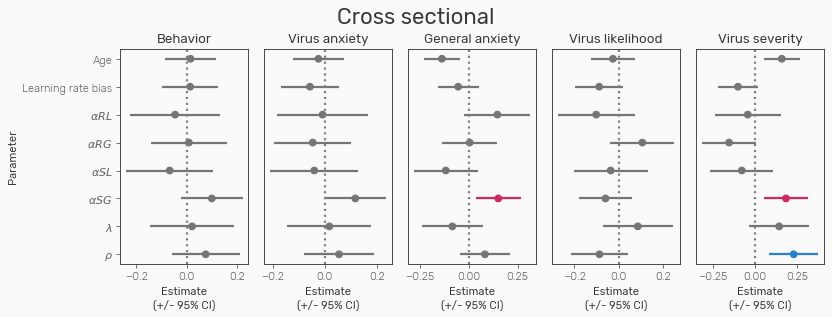

In [19]:
mb_models = [i for i in model_names if '_MB' in i]

f, ax = plt.subplots(1, len(mb_models), figsize=(2.1 * len(mb_models), 4))

ycolours = np.array(['#757575'] * (len(MB_var_labels) + 1))
ycolours[0] = colours[0]
ycolours[1] = colours[2]
ycolours[[2, 3, 4, 5]] = colours[1]
ycolours[6] = colours[3]
    
for n, m in enumerate(mb_models):
    if n == 0:
        plot_LC(latent_path_model_summaries[latent_path_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=MB_var_labels + ['Age'], ycolours=ycolours, ylabel='Parameter')
    else:
        plot_LC(latent_path_model_summaries[latent_path_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=[], ycolours=ycolours)
    
plt.tight_layout()

f.suptitle('Cross sectional', fontsize=20)
plt.subplots_adjust(top=0.85)

# plt.savefig('../figures/factors_cross_sectional_revised.svg')

## SES

In [21]:
latent_path_model_summaries = pd.read_csv('../data/sem_outputs/latent_path_model_summaries_SES.csv')

latent_path_model_summaries['model_name'] = latent_path_model_summaries['model_name'] + '_' + latent_path_model_summaries['lhs']
model_names = latent_path_model_summaries['model_name'].unique()

titles = ['Behavior', 'Virus anxiety', 'General anxiety', 'Virus likelihood', 'Virus severity']
MB_var_labels = [r'$\rho$', r'$\lambda$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', r'$\alpha_{RG}$', r'$\alpha_{RL}$', 'Learning rate bias']

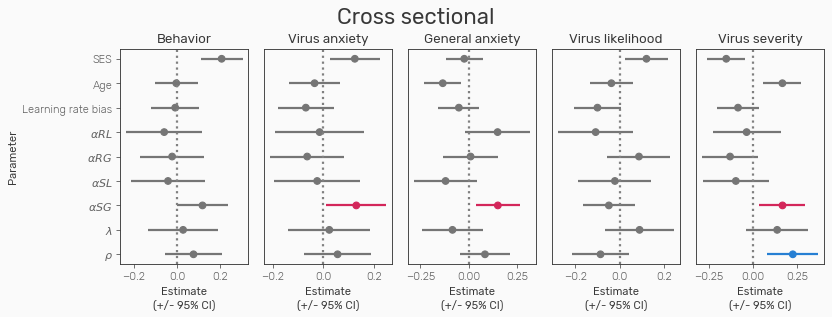

In [24]:
mb_models = [i for i in model_names if '_MB' in i]

f, ax = plt.subplots(1, len(mb_models), figsize=(2.1 * len(mb_models), 4))

ycolours = np.array(['#757575'] * (len(MB_var_labels) + 2))
ycolours[0] = colours[0]
ycolours[1] = colours[2]
ycolours[[2, 3, 4, 5]] = colours[1]
ycolours[6] = colours[3]
    
for n, m in enumerate(mb_models):
    if n == 0:
        plot_LC(latent_path_model_summaries[latent_path_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=MB_var_labels + ['Age', 'SES'], ycolours=ycolours, ylabel='Parameter')
    else:
        plot_LC(latent_path_model_summaries[latent_path_model_summaries['model_name'] == m], ax=ax[n], title=titles[n], ylabels=[], ycolours=ycolours)
    
plt.tight_layout()

f.suptitle('Cross sectional', fontsize=20)
plt.subplots_adjust(top=0.85)

# plt.savefig('../figures/factors_cross_sectional_SES_revised.svg')

## Change in factor scores over time

Here we load factor scores for each time point, along with the latent change scores for each subject.

In [74]:
factor_scores_change = pd.read_csv('../data/factor_scores_long.csv')
latent_change_scores = pd.read_csv('../data/factor_scores_wide.csv')

In [75]:
factor_scores_change.head()

,factor,time_point,score
0,virus_anxiety,T1,41.295309
1,general_anxiety,T1,1.063784
2,virus_likelihood,T1,50.251082
3,virus_severity,T1,39.291219
4,behavior,T1,8.542791


In [76]:
factor_scores_change = factor_scores_change.replace({'virus_anxiety': 'Virus\nanxiety',
                             'general_anxiety': 'General\nanxiety', 
                             'virus_likelihood': 'Virus\nlikelihood',
                             'virus_severity': 'Virus\nseverity',
                             'behavior': 'Behavior'})
factor_scores_change = factor_scores_change.rename(columns={'score': 'Score', 'time_point': 'Time'})

In [77]:
latent_change_scores = latent_change_scores[[c for c in latent_change_scores.columns if '_d' in c or 'id' in c]]
latent_change_scores = latent_change_scores.melt(id_vars='id', var_name='factor', value_name='Score')

latent_change_scores = latent_change_scores.replace({'virus_anxiety__dT1': 'Virus\nanxiety',
                             'general_anxiety__dT1': 'General\nanxiety', 
                             'virus_likelihood__dT1': 'Virus\nlikelihood',
                             'virus_severity__dT1': 'Virus\nseverity',
                             'behavior__dT1': 'Behavior'})

### Run t-tests and plot change over time

Here we run one-sample t-tests on the change scores to determine whether they differ from zero (i.e. no change) across the sample.

We also create plots showing factor scores at both timepoints for each subject, along with histograms showing the distribution of change scores.

            T  dof       tail  p-val         CI95%  cohen-d      BF10  power
T-test  4.796  258  two-sided    0.0  [2.48, 5.94]    0.298  3775.898  0.998
            T  dof       tail  p-val          CI95%  cohen-d   BF10  power
T-test  0.877  258  two-sided  0.382  [-0.05, 0.12]    0.054  0.102  0.141
            T  dof       tail  p-val          CI95%  cohen-d   BF10  power
T-test -0.807  258  two-sided   0.42  [-2.45, 1.03]     0.05  0.096  0.127
            T  dof       tail  p-val         CI95%  cohen-d       BF10  power
T-test  7.397  258  two-sided    0.0  [3.29, 5.67]     0.46  3.241e+09    1.0
             T  dof       tail  p-val           CI95%  cohen-d       BF10  \
T-test  19.727  258  two-sided    0.0  [25.33, 30.95]    1.226  9.253e+49   

        power  
T-test    1.0  


C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


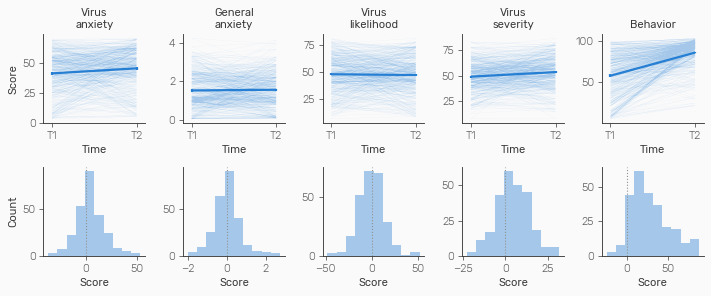

In [57]:
f, ax = plt.subplots(2, 5, figsize=(9, 3.8))

def errorplot(x, y, data, ax, **kwargs):
    m = data.groupby(x)[y].mean()
    se = data.groupby(x)[y].sem()
    ax.errorbar(m.index, m, yerr=se, **kwargs)
    ax.set_xlim(-0.1, 1.1)

# Plot change over time
for n, i in enumerate(factor_scores_change['factor'].unique()):
    temp_data = factor_scores_change[factor_scores_change['factor'] == i]
    errorplot('Time', 'Score', temp_data, ax[0, n], color=colours[0], linewidth=2)
    ax[0, n].plot('Time', 'Score', data=temp_data, color=colours[0], alpha=0.4, linewidth=0.05)
    ax[0, n].set_title(i, fontsize=10)
    ax[0, n].set_xlabel('Time')
ax[0, 0].set_ylabel('Score')

# Plot change score histograms
for n, i in enumerate(latent_change_scores['factor'].unique()):
    temp_data = latent_change_scores[latent_change_scores['factor'] == i]
    
    # Significance of change
#     t, p = ttest_1samp(temp_data['Score'], 0)
#     print('t({2}) = {1}, p = {3}'.format(i, np.round(t, 2), len(temp_data) -1, np.round(p, 3)))
    print(ttest(temp_data['Score'], 0).round(3))
    
    ax[1, n].hist(temp_data['Score'], color=colours[0], alpha=0.4, linewidth=0.05)
    ax[1, n].set_xlabel('Score')
    ax[1, n].axvline(0, linestyle=':', color='#919191')
ax[1, 0].set_ylabel('Count')

sns.despine()

plt.tight_layout()

# plt.savefig('../figures/factor_scores_change.svg')

## Relationships between change scores and behaviour

Here we create scatterplots displaying correlations between change scores and behaviour for the purpose of illustrating these relationships

In [78]:
cross_sectional_data = pd.read_csv('../data/T1_combined_data.csv')
latent_scores = pd.read_csv('../data/factor_scores_wide.csv')
latent_scores = pd.merge(latent_scores, cross_sectional_data, on='id')

### Plot relationships between behaviour and change scores

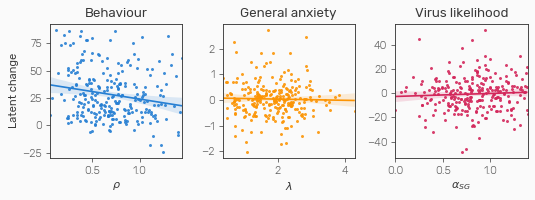

In [80]:
f, ax = plt.subplots(1, 3, figsize=(6.8, 2.6), dpi=80)

sns.regplot('rho', 'behavior__dT1', data=latent_scores, color=colours[0], ax=ax[0], scatter_kws={'s': 3})
ax[0].set_ylabel('Latent change')
ax[0].set_title('Behaviour')
ax[0].set_xlabel(r'$\rho$')

sns.regplot('lambda', 'general_anxiety__dT1', data=latent_scores, color=colours[2], ax=ax[1], scatter_kws={'s': 3})
ax[1].set_ylabel('')
ax[1].set_title('General anxiety')
ax[1].set_xlabel(r'$\lambda$')

sns.regplot('alpha_sg', 'virus_likelihood__dT1', data=latent_scores, color=colours[1], ax=ax[2], scatter_kws={'s': 3})
ax[2].set_ylabel('')
ax[2].set_title('Virus likelihood')
ax[2].set_xlabel(r'$\alpha_{SG}$')

plt.tight_layout()

# plt.savefig('../figures/longitudinal_scatter_plots_revised.svg')

## Relationships between factor scores and behaviour at T1

This does the same for the cross-sectional results

### Scatterplots

In [81]:
cross_sectional_data = pd.read_csv('../data/T1_combined_data.csv')
T1_factor_scores = pd.read_csv('../data/T1_factor_scores.csv')

In [82]:
cross_sectional_data = pd.merge(cross_sectional_data, T1_factor_scores, on='id')

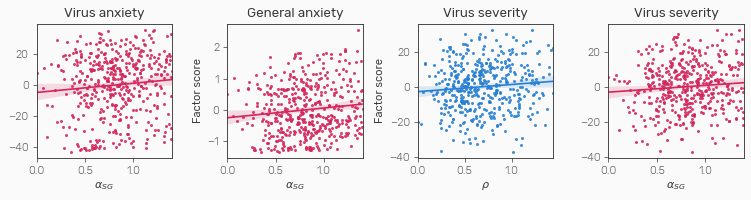

In [87]:
f, ax = plt.subplots(1, 4, figsize=(9.5, 2.6), dpi=80)

sns.regplot('alpha_sg', 'Virus_anxiety__T1', data=cross_sectional_data, color=colours[1], ax=ax[0], scatter_kws={'s': 3})
ax[0].set_ylabel('')
ax[0].set_title('Virus anxiety')
ax[0].set_xlabel(r'$\alpha_{SG}$')

sns.regplot('alpha_sg', 'General_anxiety__T1', data=cross_sectional_data, color=colours[1], ax=ax[1], scatter_kws={'s': 3})
ax[1].set_ylabel('Factor score')
ax[1].set_title('General anxiety')
ax[1].set_xlabel(r'$\alpha_{SG}$')

sns.regplot('rho', 'Virus_severity__T1', data=cross_sectional_data, color=colours[0], ax=ax[2], scatter_kws={'s': 3})
ax[2].set_ylabel('Factor score')
ax[2].set_title('Virus severity')
ax[2].set_xlabel(r'$\rho$')

sns.regplot('alpha_sg', 'Virus_severity__T1', data=cross_sectional_data, color=colours[1], ax=ax[3], scatter_kws={'s': 3})
ax[3].set_ylabel('')
ax[3].set_title('Virus severity')
ax[3].set_xlabel(r'$\alpha_{SG}$')

plt.tight_layout()

# plt.savefig('../figures/cross_sectional_scatter_plots_revised.svg')

## COVID-19 pandemic situation

Here we create a figure showing the case and death counts during the time period where the study was conducted. We also include mobility data taken from Google's covid mobility resource (https://www.google.com/covid19/mobility/)

In [36]:
covid_data = pd.read_csv('../us_covid_data.csv')

In [37]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [38]:
covid_data = covid_data[covid_data['date'] >= '2020-03-07']
covid_data = covid_data[covid_data['date'] <= '2020-05-15']

In [39]:
movement_data = pd.read_csv('../Global_Mobility_Report.csv')
movement_data = movement_data[movement_data['country_region_code'] == 'US']
movement_data = movement_data.groupby('date').mean().reset_index()
movement_data['all_sector'] = movement_data.filter(like='percent').reset_index().iloc[:, 1:-1].mean(axis=1)
movement_data['date'] = pd.to_datetime(movement_data['date'])
movement_data = movement_data.sort_values('date')
movement_data = movement_data[movement_data['date'] >= '2020-03-07']
movement_data = movement_data[movement_data['date'] < '2020-05-16']

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [40]:
covid_data = pd.merge(covid_data, movement_data[['date', 'all_sector']], on='date')

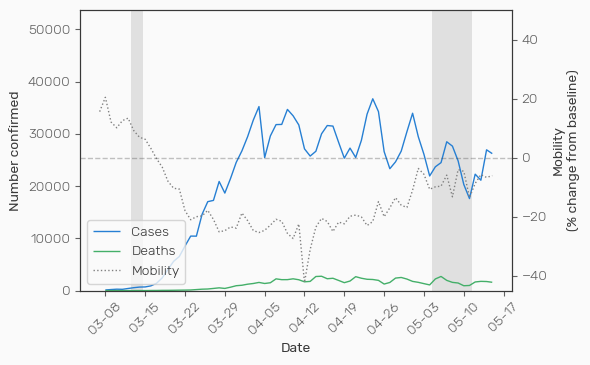

In [49]:
f, ax = plt.subplots(figsize=(6, 3.75), dpi=100)

# Cases/deaths
a, = ax.plot(covid_data['date'].astype('O'), covid_data['cases'].diff(), color=colours[0], label='Cases')
b, = ax.plot(covid_data['date'].astype('O'), covid_data['deaths'].diff(), color=colours[3], label='Deaths')

# Mobility
secax = ax.twinx()
secax.set_ylabel('Mobility\n(% change from baseline)')
c, = secax.plot(covid_data['date'].astype('O'), covid_data['all_sector'], color='gray', label='Mobility', linestyle=':')
secax.axhline(0, linestyle='--', alpha=0.3)
secax.set_ylim(-45, 50)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Number confirmed')
ax.set_ylim(0, covid_data['cases'].diff().max() + 17000)

ax.axvspan(ax.get_xlim()[0]+9, ax.get_xlim()[0]+11, facecolor='#7a7a7a', alpha=0.2)
ax.axvspan(ax.get_xlim()[1]-14, ax.get_xlim()[1]-7, facecolor='#7a7a7a', alpha=0.2)

# f.autofmt_xdate()
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))

# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
# ax.legend(loc="center left")
p = [a, b, c]
ax.legend(p, [p_.get_label() for p_ in p], loc= 'lower left')

rect1 = patches.Rectangle((ax.get_xlim()[0]+0.2, 1500), ax.get_xlim()[1] - ax.get_xlim()[0], 650, facecolor='#fafafa', alpha=1, zorder=100, linestyle=':', edgecolor='None')
rect2 = patches.Rectangle((ax.get_xlim()[1]-16, 600), 11, 400, facecolor='#ededed', alpha=1, zorder=100, linestyle=':', edgecolor='None')

ax.text(ax.get_xlim()[0] + 2, 1600, 'T1', zorder=200, size=15)
ax.text(ax.get_xlim()[1] - 20, 1600, 'T2', zorder=200, size=15)

ax.plot([pd.to_datetime('03-12-2020')] * 2, [0, 1000], color='#303030')
ax.text(pd.to_datetime('03-08-2020'), 1050, 'WHO\ndeclares\npandemic', rotation=45)

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.tight_layout()

plt.savefig('../figures/covid_time_figure.svg')
